# In this notebook, we have the code to train a GAN for the multi minst data

In [9]:
import torch
import torch.optim as optim
from dataloaders import get_mnist_dataloaders, get_multi_mnist_dataloaders
from models import Generator_5layers, Discriminator_5layers
from training import Trainer
from torch.utils.data import Dataset
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data_loader, _ = get_multi_mnist_dataloaders(image_size = 64,
                    path= "data/multi_mnist/MNIST_synthetic_31_3.h5", batch_size=64)


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import make_grid
from torch.autograd import Variable
import numpy as np


class Generator_layers(nn.Module):
    def __init__(self, img_size, latent_dim, dim):
        super(Generator_5layers, self).__init__()

        self.dim = dim
        self.latent_dim = latent_dim
        self.img_size = img_size
        self.feature_sizes = int(self.img_size[0] / 64), int(self.img_size[1] / 64)

        self.latent_to_features = nn.Sequential(
            nn.Linear(latent_dim, 32 * dim * self.feature_sizes[0] * self.feature_sizes[1]),
            nn.ReLU()
        )

        self.features_to_image = nn.Sequential(
            nn.ConvTranspose2d(32 * dim, 16 * dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(16 * dim),
            nn.ConvTranspose2d(16 * dim, 8 * dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(8 * dim),
            nn.ConvTranspose2d(8 * dim, 4 * dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(4 * dim),
            nn.ConvTranspose2d(4 * dim, 2 * dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(2 * dim),
            nn.ConvTranspose2d(2 * dim, dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(dim),
            nn.ConvTranspose2d(dim, self.img_size[2], 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        # Map latent into appropriate size for transposed convolutions
        x = self.latent_to_features(input_data)
        # Reshape
        x = x.view(-1, 32 * self.dim, self.feature_sizes[0], self.feature_sizes[1])
        # Return generated image
        return self.features_to_image(x)

    def sample_latent(self, num_samples):
        return torch.randn((num_samples, self.latent_dim))

class Discriminator_5layers(nn.Module):
    def __init__(self, img_size, dim):
        """
        img_size : (int, int, int)
            Height and width must be powers of 2.  E.g. (32, 32, 1) or
            (64, 128, 3). Last number indicates number of channels, e.g. 1 for
            grayscale or 3 for RGB
        """
        super(Discriminator_5layers, self).__init__()

        self.img_size = img_size

        self.image_to_features = nn.Sequential(
            nn.Conv2d(self.img_size[2], dim, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(dim, 2 * dim, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(2 * dim, 4 * dim, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(4 * dim, 8 * dim, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(8 * dim, 16 * dim, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16 * dim, 32 * dim, 4, 2, 1),
            nn.Sigmoid()
        )

        # 4 convolutions of stride 2, i.e. halving of size everytime
        # So output size will be 8 * (img_size / 2 ^ 4) * (img_size / 2 ^ 4)
        output_size = int(32 * dim * (img_size[0] / 64) * (img_size[1] / 64))
        self.features_to_prob = nn.Sequential(
            nn.Linear(output_size, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        batch_size = input_data.size()[0]
        x = self.image_to_features(input_data)
        x = x.view(batch_size, -1)
        return self.features_to_prob(x)

In [12]:
latent_dim = 200
img_size = (64, 64, 1)
generator = Generator_5layers(img_size=img_size, latent_dim=latent_dim, dim=64)
discriminator = Discriminator_5layers(img_size=img_size, dim=64)

print(generator)
print(discriminator)

Generator_5layers(
  (latent_to_features): Sequential(
    (0): Linear(in_features=200, out_features=2048, bias=True)
    (1): ReLU()
  )
  (features_to_image): Sequential(
    (0): ConvTranspose2d(2048, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4)

torch.Size([1, 200])
torch.Size([1, 1, 64, 64])


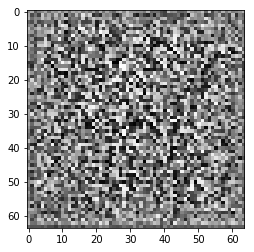

prob  tensor(0.4230, grad_fn=<SelectBackward>)


In [14]:
num_samples = 1

rand_img = torch.randn((num_samples, latent_dim))
print(np.shape(rand_img))
im = generator(rand_img)
print(np.shape(im))
tmp = im
stacked_img = np.stack((tmp.detach().numpy()[0][0],)*3, axis=-1)
plt.imshow(stacked_img)
plt.show()

prob = discriminator(im)
print("prob ", prob[0][0])

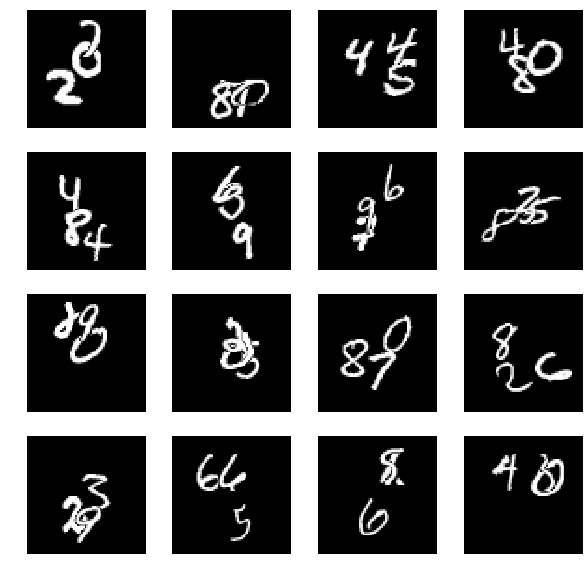

In [15]:
def show_sample_data(data_loader, n,m):

    plt.figure(figsize=(10,10))

    for data in data_loader:
        im = data[0]
        label = data[1]
        seg = data[2]

        for i in range(n*m):
            plt.subplot(n,m,i+1)
            img = np.asarray(im[i])
            stacked_img = np.stack((img[0,:,:],)*3, axis=-1)
            plt.imshow(stacked_img)
            plt.axis('off')

        break
    plt.show()
    
show_sample_data(data_loader, 4, 4)

In [16]:
# Initialize optimizers
lr = 1e-4
betas = (.9, .99)
G_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=betas)
D_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

In [ ]:
# Train model
epochs = 200
trainer = Trainer(generator, discriminator, G_optimizer, D_optimizer,
                  use_cuda=torch.cuda.is_available())
trainer.train(data_loader, epochs, save_training_gif=True, jupyter_notebook=True, save_model= True)

WARNING - we will overwrite folder named:  2019-04-18

Epoch 1
